In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import sys
sys.path.append("..")
import statnlpbook.util as util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# Word-based Machine Translation

Machine Translation (MT) is one of the canonical NLP applications, and one that nowadays most people are familiar with, primarily through online translation services of the major search engine providers. While there is still some way to go before machines can provide fluent and flawless translations, in particular for more distant language pairs like English and Japanese, progress in this field has been remarkable. 

In this chapter we will illustrate the foundations of this progress, and focus on word-based machine translation models. In such models words are the basic unit of translation. Nowadays the field has mostly moved to phrase and syntax-based approaches, but the word-based approach is still important, both from a foundational point of view, and as sub-component in more complex approaches.

## MT as Structured Prediction

Formally we will see MT as the task of translating a _source_ sentence \\(\source\\) to a _target_ sentence \\(\target\\). We can tackle the problem using the [structured prediction recipe](structured_prediction.ipynb): We define a parametrised model \\(s_\params(\target,\source)\\) that measures how well a target  \\(\target\\) sentence matches a source sentence \\(\source\\), learn the parameters \\(\params\\) from training data, and then find

\begin{equation}\label{decode-mt}
\argmax_\target s_\params(\target,\source)
\end{equation}

as translation of \\(\source\\). Different _statistical_ MT approaches, in this view, differ primarily in how \\(s\\) is defined, \\(\params\\) are learned, and how the \\(\argmax\\) is found.

## Noisy Channel Model for MT

Many Word-based MT systems, as well as those based on more advanced representations, rely on a [Noisy Channel](https://www.dropbox.com/s/gfucv538m6anmgd/NoisyChannel.pdf?dl=0) model as choice for the scoring function \\(s_\params\\). In this approach to MT we effectively model the translation process *in reverse*. That is, we assume that a probabilistic process (the speaker's brain) first generates the target sentence \\(\target\\) according to the distribution \\(\prob(\target)\\). Then the target sentence \\(\target\\) is transmitted through a _noisy channel_ \\(\prob(\source|\target)\\) that translates \\(\target\\) into \\(\source\\). 

Hence translation is seen as adding noise to a clean \\(\target\\). This _generative story_ defines a _joint distribution_ over target and source sentences \\(\prob(\source,\target) = \prob(\target) \prob(\source|\target) \\). We can in turn operate this distribution in the direction we actually care about: to infer a target sentence \\(\target\\) given a source sentence \\(\source\\) we find the _maximum a posteriori_ sentence

\begin{equation}
\label{decode-nc}
\target^* = \argmax_\target \prob(\target | \source) = \argmax_\target \prob(\target) \, \prob(\source | \target). 
\end{equation}

For the structured prediction recipe this means setting 

$$
s_\params(\target,\source) = \prob(\target) \, \prob(\source | \target). 
$$

In the noisy channel approach for MT the distribution \\(\prob(\target)\\) that generates the target sentence is usually referred to as [language model](/template/statnlpbook/01_tasks/01_languagemodels), and the noisy channel is called the _translation model_. As we have discussed language models earlier, in this chapter we focus on the translation model \\(\prob(\source|\target)\\).

## A Naive Baseline Translation Model
The most straightforward translation model translates words one-by-one, in the order of appearance:
$$
\prob_\params^\text{Naive}(\ssource|\starget) = \prod_i^{\length{\source}} \param_{\ssource_i,\starget_i}
$$
where \\(\param_{\ssource,\starget} \\) is the probability of translating \\(\starget\\) as \\(\ssource\\). \\(\params\\) is often referred to as *translation table*.

For many language pairs one can acquire training sets \\(\train=\left( \left(\source_i,\target_i\right) \right)_{i=1}^n \\) of paired source and target sentences. For example, for French and English the [Aligned Hansards](http://www.isi.edu/natural-language/download/hansard/) of the Parliament of Canada can be used. Given such a training set \\(\train\\) we can learn the parameters \\(\params\\) using the [Maximum Likelhood estimator](/template/statnlpbook/02_methods/0x_mle). In the case of our Naive model this amounts to setting
$$
\param_{\ssource,\starget} = \frac{\counts{\train}{s,t}}{\counts{\train}{t}} 
$$
Here \\(\counts{\train}{s,t}\\) is the number of times we see target word \\(t\\) translated as source word \\(s\\), and \\(\counts{\train}{t}\\) the number of times we the target word \\(t\\) in total.

### Training the Naive Model
Let us prepare some toy data to show how train this naive model.

In [11]:
train_raw = [
    ("the house is small", "das Haus ist klein"),
    ("the house is small", "klein ist das Haus"),
    ("a man is tall", "ein Mann ist groß"),
    ("my house is small", "klein ist mein Haus")
]
train = [(t.split(" "), s.split(" ")) for t,s in train_raw]
train

[(['the', 'house', 'is', 'small'], ['das', 'Haus', 'ist', 'klein']),
 (['the', 'house', 'is', 'small'], ['klein', 'ist', 'das', 'Haus']),
 (['a', 'man', 'is', 'tall'], ['ein', 'Mann', 'ist', 'groß']),
 (['my', 'house', 'is', 'small'], ['klein', 'ist', 'mein', 'Haus'])]

Notice how we transformed raw strings into tokenised sentences via `split`. This dataset can be used to train the naive model as follows. 

In [28]:
from collections import defaultdict 
def learn_naive_model(data):
    norm = defaultdict(float)
    counts = defaultdict(float)
    for target, source in data:
        for i in range(0, len(target)):
            norm[target[i]] += 1.0
            counts[(source[i],target[i])] += 1.0
    result = {}
    for (source,target),score in counts.items():
        result[(source,target)] = score / norm[target]
    return result

Let us train on the toy dataset:

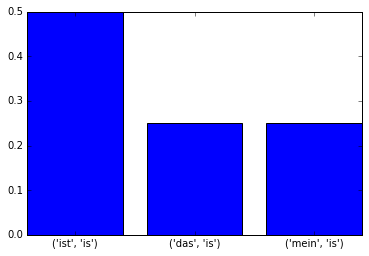

In [29]:
table = learn_naive_model(train)
source_for_is, scores = zip(*[item for item in table.items() if item[0][1] == 'is'])
list(source_for_is)
util.plot_bar_graph(scores, source_for_is)